# MODELING PERFORMANCE OF STUDENTS IN MATHEMATICS, APPLICATION OF MACHINE LEARNING.

# ML workflow implementation for students' performance analysis.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score # Added precision_score, recall_score, f1_score
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# 1. Data cleaning and preprocessing

In [2]:
# Load Dataset
df = pd.read_csv("/content/Dataset.csv")

# Display basic info
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Number          364 non-null    int64  
 1   Mark            364 non-null    float64
 2   Grade           364 non-null    int64  
 3   Gender          364 non-null    int64  
 4   Age             364 non-null    int64  
 5   PO              364 non-null    object 
 6   FFS             364 non-null    object 
 7   Fsupport        364 non-null    object 
 8   PocketMoney     364 non-null    object 
 9   Feeding         364 non-null    int64  
 10  Distance        364 non-null    int64  
 11  NegativeIH      364 non-null    object 
 12  QualityTeacher  364 non-null    object 
 13  TStR            364 non-null    object 
 14  NRoll           364 non-null    int64  
 15   PVC            364 non-null    object 
 16  CondC           364 non-null    object 
 17  DYESM           364 n

In [3]:
# Print first few observations
df.head()

,Number,Mark,Grade,Gender,Age,PO,FFS,Fsupport,PocketMoney,Feeding,...,CondC,DYESM,SH,HODYDH,DYMS,ALM,ExtC,ExtraCA,Activity,NIOA
0,1,6.0,6,0,1,Trader,M,Good,6-10 cedis,2,...,Yes,Yes,2 hours and above,Regularly,Sometimes,Yes,Yes,No,NaN,NaN
1,2,8.0,6,0,1,2mer,Low,Fair,2-5 cedis,3,...,Yes,No,1 hour,Irregularly,Sometimes,Yes,No,Yes,Sports,No
2,3,8.0,6,0,1,Cleaner,Low,Fair,6-10 cedis,2,...,Yes,Yes,1 hour,Irregularly,Sometimes,Yes,Yes,Yes,Sports,Yes
3,4,9.0,6,1,2,Travel Agent,high,Good,11 cedis and above,2,...,Yes,Yes,1 hour,Regularly,Not at all,Yes,Yes,No,NaN,NaN
4,5,9.0,6,0,1,Contractor,M,Good,2-5 cedis,2,...,Maybe,Yes,1 hour,Not at all,Sometimes,Yes,No,No,NaN,NaN


In [4]:
# Identify columns with potential unique points (categorical features)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Iterate through categorical columns and print unique values
for col in categorical_cols:
  print(f"\nUnique values in column '{col}':")
  print(df[col].unique())



Unique values in column 'PO':
['Trader' '2mer' 'Cleaner' 'Travel Agent' 'Contractor' 'Teacher' 'Caterer'
 'Mason' 'Driver' 'Carpenter' 'Doctor' 'Dress maker' 'Baker' 'Herbalist'
 'Banker' 'Pastor' 'Pharmacist' 'Land Surveyor' 'Lecturer'
 'Cyber Security Analyst' 'Technician' 'Auditor' 'Chief Registrar'
 'Secretary' 'DVLA worker' 'Civil Servant' 'Accountant' 'Engineer'
 'Administrator' 'Health worker' 'Physician Assistant' 'Dietician' 'Nurse'
 'Cosmetologyist' 'Welder' ' Engineer ' 'Hall Assistant' 'Trader '
 'Clergy' 'Businessman' 'Cashier' 'Member of Parliament' 'AstroNomist'
 'Entrepreneur' 'Lawyer' 'Researcher' 'Public servant' 'Educationalist'
 'Beautician' 'Phamarcist' 'Mechanic' 'Architect' 'Lab Technician'
 'Constructor' 'Artist' 'Adminstrator' 'TranSports Officer' 'Pilot'
 'Police' 'Dress Maker' 'Blacksmith' 'Baking' ' Contractor' 'Forestry'
 'Tailor']

Unique values in column 'FFS':
['M' 'Low' 'high']

Unique values in column 'Fsupport':
['Good' 'Fair' 'Poor']

Unique values 

In [5]:
# Check for missing values
print(df.isnull().sum())

Number              0
Mark                0
Grade               0
Gender              0
Age                 0
PO                  0
FFS                 0
Fsupport            0
PocketMoney         0
Feeding             0
Distance            0
NegativeIH          0
QualityTeacher      0
TStR                0
NRoll               0
 PVC                0
CondC               0
DYESM               0
SH                  0
HODYDH              0
DYMS                0
ALM                 0
ExtC                0
ExtraCA             0
Activity          262
 NIOA             266
dtype: int64


In [6]:
#  Drop Identifier and High-Missing Columns
df.drop(columns=["Number", "Activity", " NIOA"], inplace=True)

In [7]:
# Separate ordinal and nominal categorical columns
ordinal_cols = ["Age", "FFS", "Fsupport", "PocketMoney", "Feeding", "Distance", "QualityTeacher", "TStR", "SH", "Grade"]
nominal_cols = df.select_dtypes(include=["object"]).columns.difference(ordinal_cols).tolist()

In [8]:
# Apply Label encodings for ordinal variables
ordinal_encoder = Pipeline(steps=[
    ("label", LabelEncoder())
])

# One-hot encoding for nominal variables
preprocessor = ColumnTransformer(transformers=[
    ("num", "passthrough", df.select_dtypes(exclude=["object"]).columns),
    ("ord", "passthrough", ordinal_cols),
    ("cat", OneHotEncoder(drop='first'), nominal_cols)
])

In [9]:
# Apply transformations manually due to LabelEncoder constraints
for col in ordinal_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

In [10]:
df.head()

,Mark,Grade,Gender,Age,FFS,Fsupport,PocketMoney,Feeding,Distance,QualityTeacher,...,PO_Researcher,PO_Secretary,PO_Tailor,PO_Teacher,PO_Technician,PO_Trader,PO_Trader,PO_TranSports Officer,PO_Travel Agent,PO_Welder
0,6.0,5,0,0,1,1,2,1,0,0,...,False,False,False,False,False,True,False,False,False,False
1,8.0,5,0,0,0,0,1,2,2,0,...,False,False,False,False,False,False,False,False,False,False
2,8.0,5,0,0,0,0,2,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,9.0,5,1,1,2,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,False
4,9.0,5,0,0,1,1,1,1,3,0,...,False,False,False,False,False,False,False,False,False,False


# Exploratory Data Analysis

<Figure size 1600x1200 with 0 Axes>

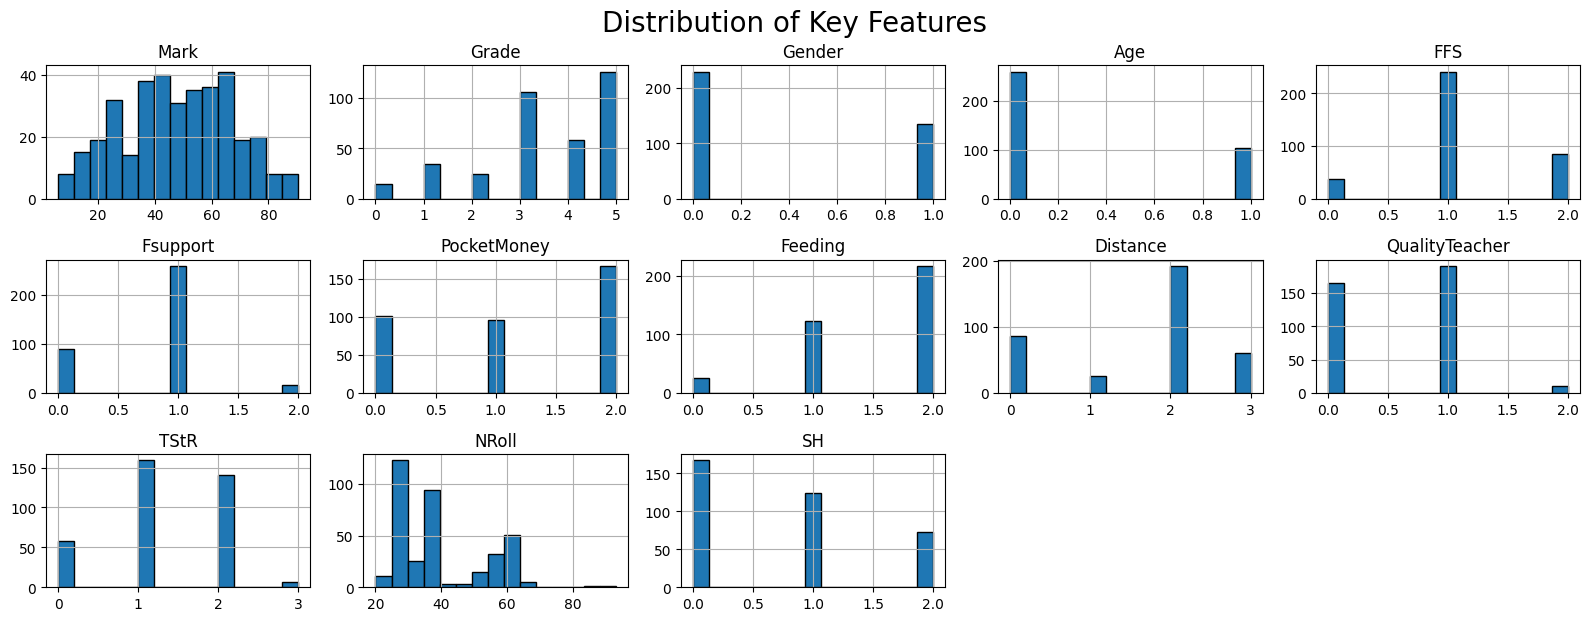

In [11]:
# Visualize distributions of numerical variables
plt.figure(figsize=(16, 12))
df.hist(bins=15, figsize=(16, 12), layout=(6, 5), edgecolor='black')
plt.suptitle("Distribution of Key Features", fontsize=20)
plt.tight_layout()
plt.show()

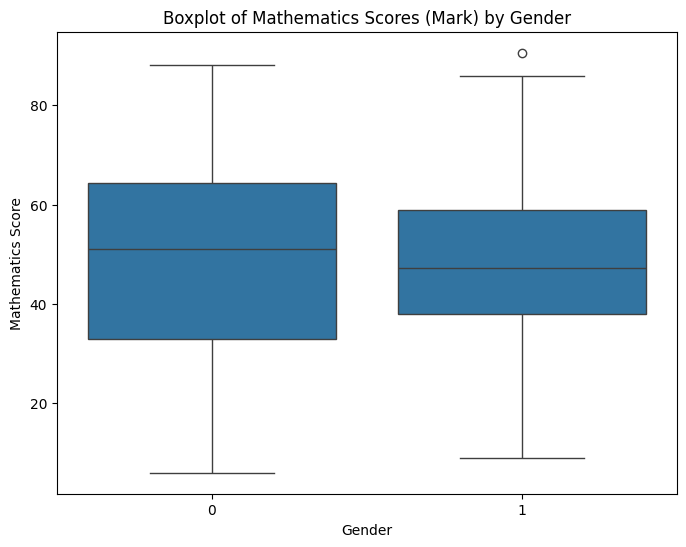

In [13]:
# Boxplot of Mathematics Scores (Mark) by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Mark', data=df)
plt.title('Boxplot of Mathematics Scores (Mark) by Gender')
plt.xlabel('Gender')
plt.ylabel('Mathematics Score')
plt.show()

In [14]:
# Percentage of Grade count
df["Grade"].value_counts(normalize=True) * 100

,proportion
Grade,
5,34.615385
3,29.120879
4,15.934066
1,9.340659
2,6.868132
0,4.120879


In [15]:
# Percentage of Gender
df["Gender"].value_counts(normalize=True) * 100

,proportion
Gender,
0,62.912088
1,37.087912


In [16]:
# Count on NRoll
print("NRoll Count:", df["NRoll"].nunique())

# Description of NRoll
print("\nNRoll Description:")
print(df["NRoll"].describe())

NRoll Count: 34

NRoll Description:
count    364.000000
mean      38.832418
std       14.222046
min       20.000000
25%       26.000000
50%       35.000000
75%       54.000000
max       93.000000
Name: NRoll, dtype: float64


In [17]:
# Percentage of QualityTeacher
df["QualityTeacher"].value_counts(normalize=True) * 100

,proportion
QualityTeacher,
1,52.197802
0,45.054945
2,2.747253


In [18]:
# Percentage of TStR
df["TStR"].value_counts(normalize=True) * 100

,proportion
TStR,
1,43.681319
2,38.736264
0,15.934066
3,1.648352


In [19]:
# Percentage of Study hours
df["SH"].value_counts(normalize=True) * 100

,proportion
SH,
0,45.879121
1,34.065934
2,20.054945


# 2. Feature engineering and selection

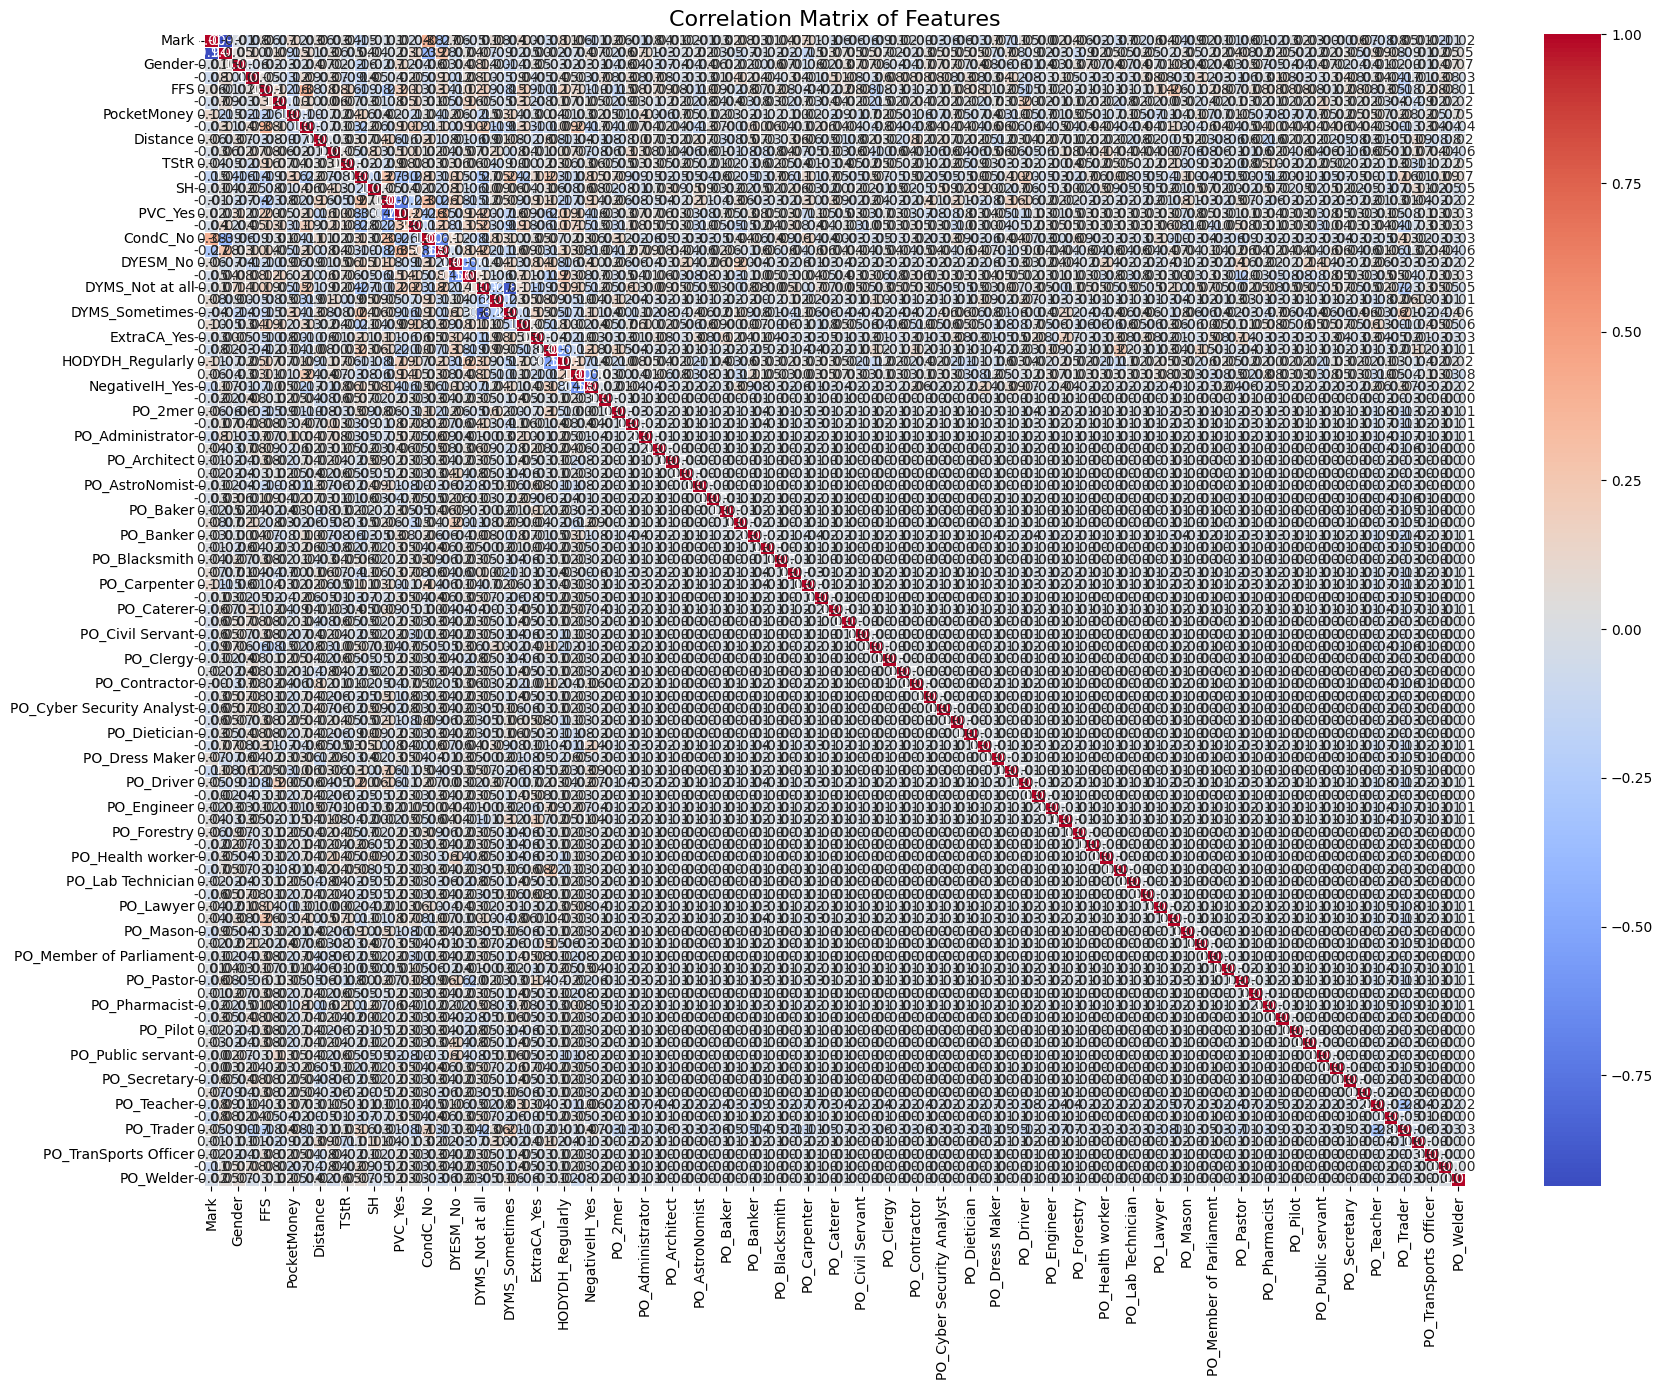

In [20]:
# Heatmap Correlation matrix to identify significant predictors
plt.figure(figsize=(18, 14))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# Overall Numerical correlation matrix
corr_matrix = df.corr()
print(corr_matrix.to_string(float_format="%.2f"))

                           Mark  Grade  Gender   Age   FFS  Fsupport  PocketMoney  Feeding  Distance  QualityTeacher  TStR  NRoll    SH   PVC_No   PVC_Yes  ALM_Yes  CondC_No  CondC_Yes  DYESM_No  DYESM_Yes  DYMS_Not at all  DYMS_Often  DYMS_Sometimes  ExtC_Yes  ExtraCA_Yes  HODYDH_Not at all  HODYDH_Regularly  NegativeIH_No  NegativeIH_Yes  PO_ Engineer   PO_2mer  PO_Accountant  PO_Administrator  PO_Adminstrator  PO_Architect  PO_Artist  PO_AstroNomist  PO_Auditor  PO_Baker  PO_Baking  PO_Banker  PO_Beautician  PO_Blacksmith  PO_Businessman  PO_Carpenter  PO_Cashier  PO_Caterer  PO_Chief Registrar  PO_Civil Servant  PO_Cleaner  PO_Clergy  PO_Constructor  PO_Contractor  PO_Cosmetologyist  PO_Cyber Security Analyst  PO_DVLA worker  PO_Dietician  PO_Doctor  PO_Dress Maker  PO_Dress maker  PO_Driver  PO_Educationalist  PO_Engineer  PO_Entrepreneur  PO_Forestry  PO_Hall Assistant  PO_Health worker  PO_Herbalist  PO_Lab Technician  PO_Land Surveyor  PO_Lawyer  PO_Lecturer  PO_Mason  PO_Mecha

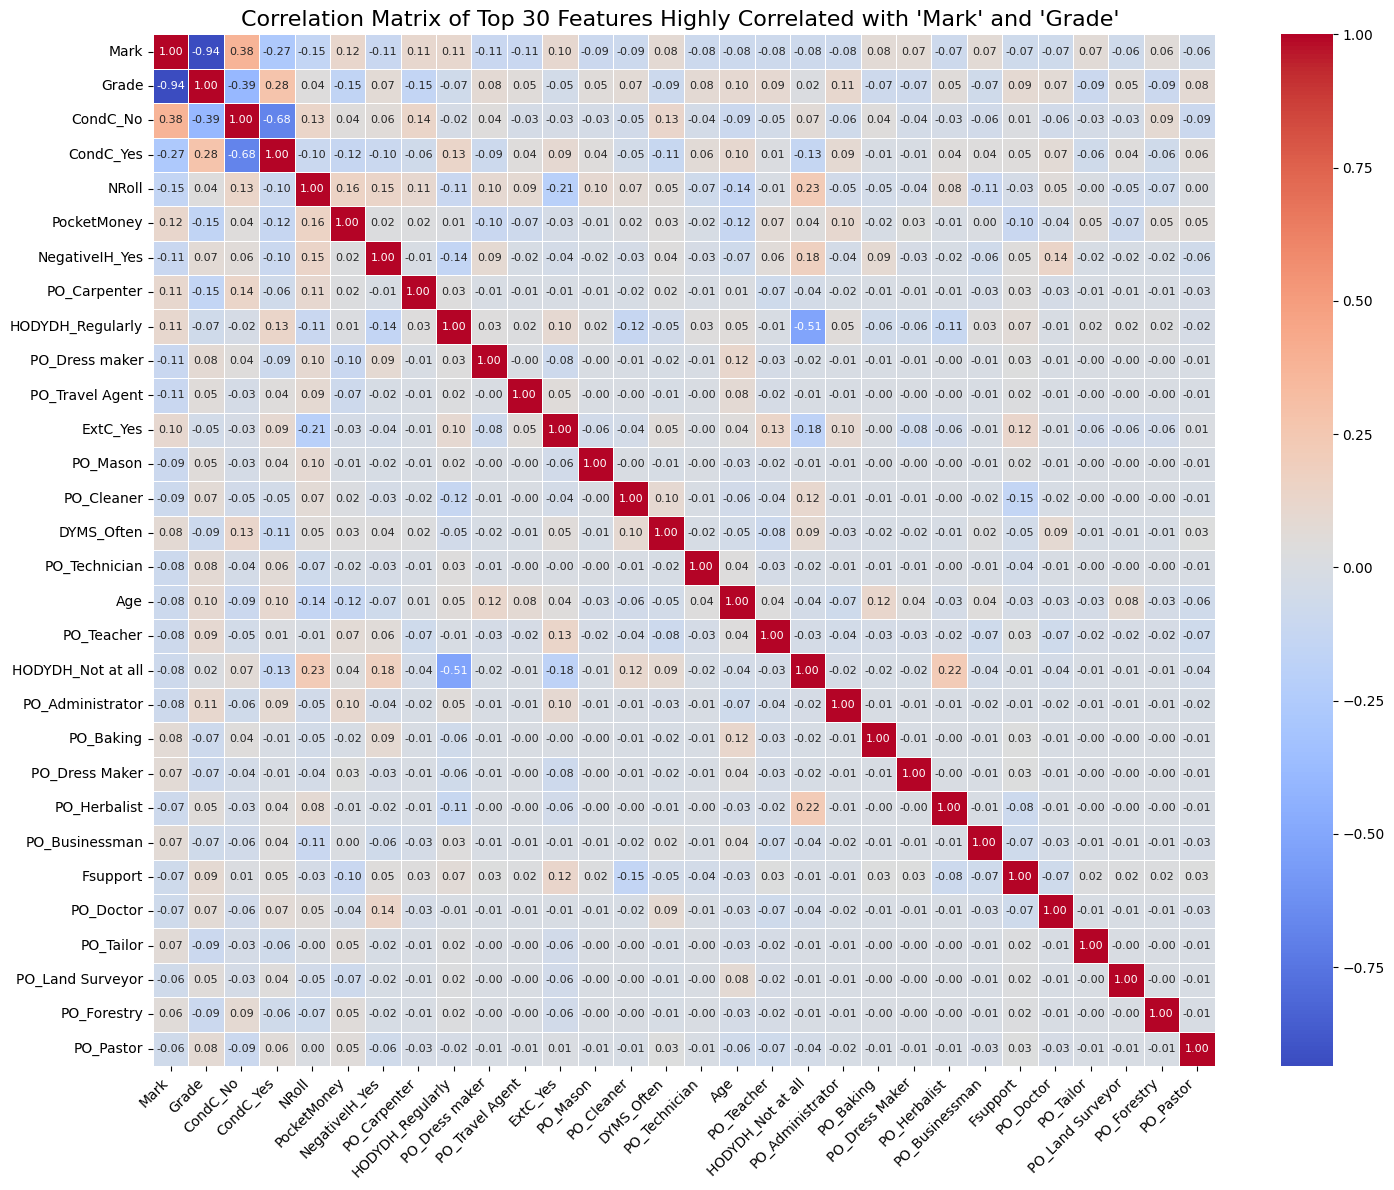

In [22]:
target_variable = 'Mark'
num_features_to_show = 30 # Adjust as needed for clarity
# Get correlations with the target variable
correlations_with_target = df.corr()[target_variable].abs().sort_values(ascending=False)

# Select the names of the top N features (including the target itself if it's in the list)
top_n_feature_names = correlations_with_target.head(num_features_to_show).index

# Create the correlation matrix for this subset
subset_corr_matrix = df[top_n_feature_names].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(subset_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 8})
plt.title(f"Correlation Matrix of Top {num_features_to_show} Features Highly Correlated with '{target_variable}' and 'Grade' ", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<ipython-input-23-4f43c9c6bd16>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=strong_corr.values, y=strong_corr.index, palette="coolwarm")


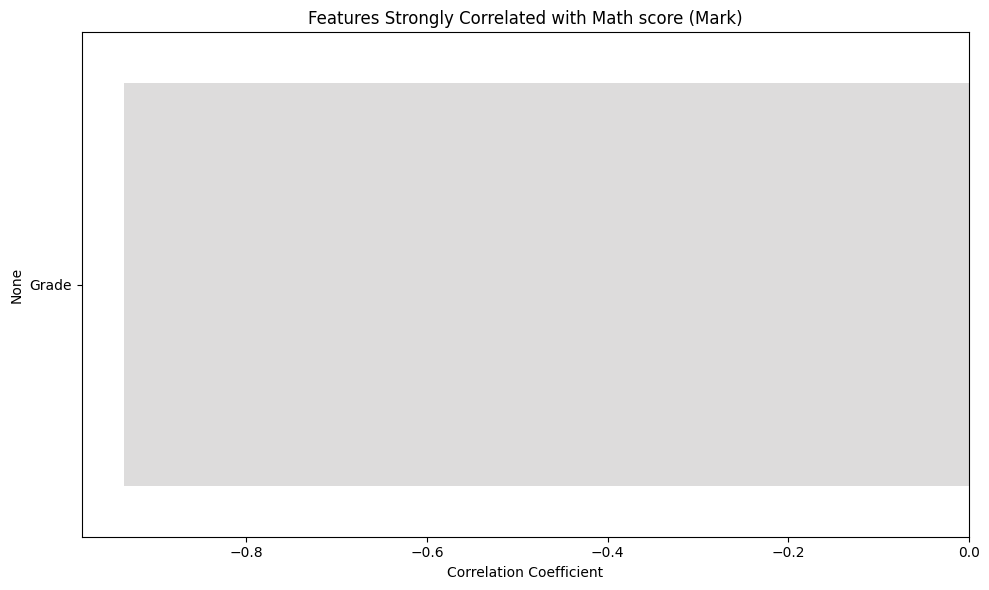

In [23]:
# Filter and plot strong correlations with target (Mark)
target_corr = corr_matrix["Mark"].drop("Mark")
strong_corr = target_corr[abs(target_corr) >= 0.5].sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=strong_corr.values, y=strong_corr.index, palette="coolwarm")
plt.title("Features Strongly Correlated with Math score (Mark)")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

# 3. Model training and validation (Classification)

In [24]:
# Classification models (Mark >= 40 as Pass)
X = df.drop(["Mark", "Grade"], axis=1)
y = (df["Mark"] >= 40).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=65)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Count on pass Mark
print("Pass Mark Count:", y.sum())

# Count on fail Mark
print("Fail Mark Count:", len(y) - y.sum())

# Pass/Fail Percentage
print("Pass Percentage:", (y.sum() / len(y)) * 100)
print("Fail Percentage:", (1 - (y.sum() / len(y))) * 100)

Pass Mark Count: 238
Fail Mark Count: 126
Pass Percentage: 65.38461538461539
Fail Percentage: 34.61538461538461


In [26]:
# Count on Gender that pass
gender_pass_counts = df[df['Mark'] >= 40]['Gender'].value_counts()

# Percentage on Gender that pass
gender_pass_percentages = gender_pass_counts / gender_pass_counts.sum() * 100

# Print both count and percentage
print("Gender Pass Counts")
print(gender_pass_counts)
print("\nGender Pass Percentages")
print(gender_pass_percentages)

Gender Pass Counts
Gender
0    149
1     89
Name: count, dtype: int64

Gender Pass Percentages
Gender
0    62.605042
1    37.394958
Name: count, dtype: float64


# Hyperparameter tuning for Classification models

In [27]:
# Decision Tree Tuning
dt_params = {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}
gs_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5)
gs_dt.fit(X_train, y_train)

# SVC Tuning with balanced class weights
svc_params = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
gs_svc = GridSearchCV(SVC(class_weight='balanced'), svc_params, cv=5)
gs_svc.fit(X_train, y_train)

models = {
    "Decision Tree (Tuned)": gs_dt.best_estimator_,
    "Support Vector Machine (Tuned)": gs_svc.best_estimator_
}

# Classification Models result


Decision Tree (Tuned) Classification Report:
              precision    recall  f1-score   support

  Fail (<40)       0.86      0.61      0.71        41
 Pass (>=40)       0.80      0.94      0.87        69

    accuracy                           0.82       110
   macro avg       0.83      0.78      0.79       110
weighted avg       0.82      0.82      0.81       110

Cross-Validation Accuracy: 0.7600, Test Accuracy: 0.8182

Support Vector Machine (Tuned) Classification Report:
              precision    recall  f1-score   support

  Fail (<40)       0.00      0.00      0.00        41
 Pass (>=40)       0.63      1.00      0.77        69

    accuracy                           0.63       110
   macro avg       0.31      0.50      0.39       110
weighted avg       0.39      0.63      0.48       110

Cross-Validation Accuracy: 0.6733, Test Accuracy: 0.6273


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


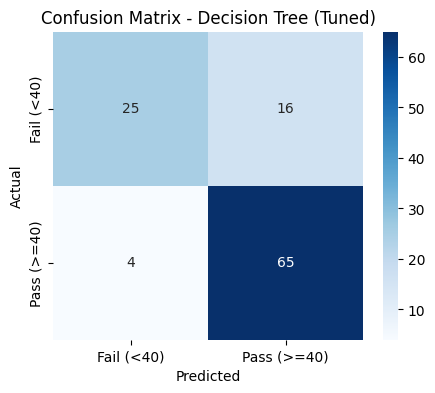

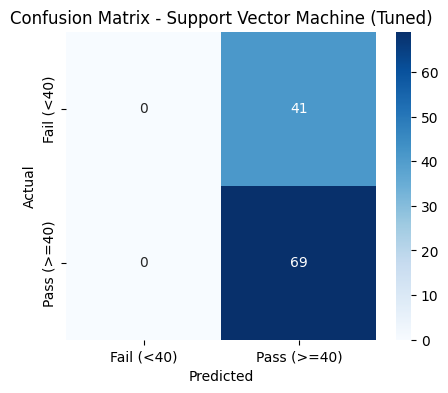

In [28]:
results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "CV Accuracy": scores.mean()
    })

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Fail (<40)", "Pass (>=40)"]))
    print(f"Cross-Validation Accuracy: {scores.mean():.4f}, Test Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    cmap = "Oranges" if "SVM" in name else "Blues"
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["Fail (<40)", "Pass (>=40)"], yticklabels=["Fail (<40)", "Pass (>=40)"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

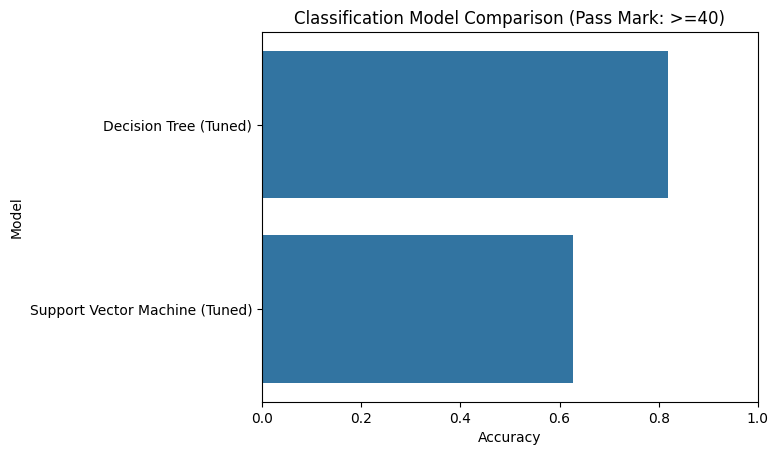

In [29]:
# Summary comparison
performance_df = pd.DataFrame(results)
performance_df = performance_df.sort_values(by="Accuracy", ascending=False)
sns.barplot(data=performance_df, x="Accuracy", y="Model")
plt.title("Classification Model Comparison (Pass Mark: >=40)")
plt.xlim(0, 1)
plt.show()

# 4. Hyperparameter tuning & Regression models training

In [35]:
# Regression Models: Predicting Mark as continuous
X_reg = df.drop(["Mark", "Grade"], axis=1)
y_reg = df["Mark"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.3, random_state=65)
scaler_r = StandardScaler()
X_train_r = scaler_r.fit_transform(X_train_r)
X_test_r = scaler_r.transform(X_test_r)

In [36]:
# Hyperparameter tuning for Random Forest Regressor
rf_params = {"n_estimators": [50, 100, 150], "max_depth": [None, 10, 20]}
gs_rf = GridSearchCV(RandomForestRegressor(), rf_params, cv=5)
gs_rf.fit(X_train_r, y_train_r)

regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regression (Tuned)": gs_rf.best_estimator_
}

# Regression model results


Linear Regression Regression Metrics:
Mean Absolute Error: 16.24
Root Mean Squared Error: 19.14
R-squared: 0.16
Cross-Validation RMSE: 20.81

Random Forest Regression (Tuned) Regression Metrics:
Mean Absolute Error: 10.76
Root Mean Squared Error: 14.67
R-squared: 0.51
Cross-Validation RMSE: 14.26


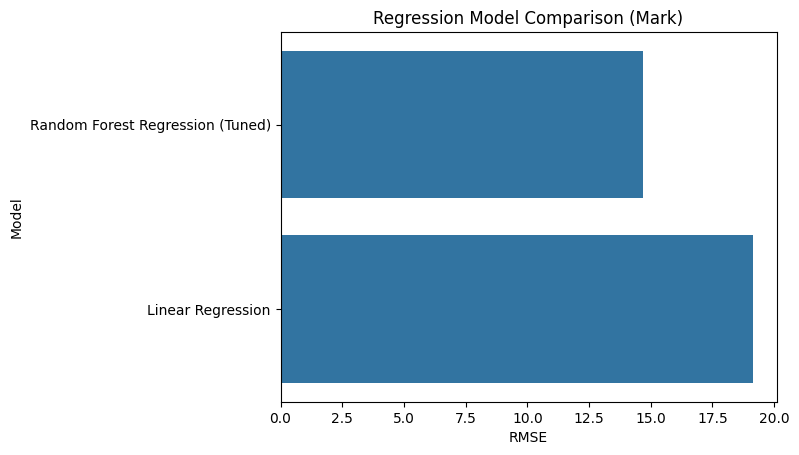

In [37]:
results_reg = []
for name, model in regressors.items():
    scores = cross_val_score(model, X_train_r, y_train_r, cv=5, scoring='neg_mean_squared_error')
    model.fit(X_train_r, y_train_r)
    y_pred_r = model.predict(X_test_r)
    mse = mean_squared_error(y_test_r, y_pred_r)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_r, y_pred_r)
    r2 = r2_score(y_test_r, y_pred_r)
    results_reg.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R-squared": r2,
        "CV RMSE": np.sqrt(-scores.mean())
    })
    print(f"\n{name} Regression Metrics:")
    print(f"Mean Absolute Error: {mae:.2f}")
    #print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print(f"Cross-Validation RMSE: {np.sqrt(-scores.mean()):.2f}")


performance_df_reg = pd.DataFrame(results_reg)
performance_df_reg = performance_df_reg.sort_values(by="RMSE", ascending=True)
sns.barplot(data=performance_df_reg, x="RMSE", y="Model")
plt.title("Regression Model Comparison (Mark)")
plt.show()


# 5. Model Evaluation (Regression)

In [38]:
for name, reg in regressors.items():
    reg.fit(X_train_r, y_train_r)
    y_pred_r = reg.predict(X_test_r)
    MAE = mean_absolute_error(y_test_r, y_pred_r)
    MSE = mean_squared_error(y_test_r, y_pred_r)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_r, y_pred_r)
    print(f"\n{name} Performance")
    print(f"Mean Absolute Error = {MAE:.2f}")
    print(f" Root Mean Squared Error = {RMSE:.2f}")
    print(f"R-squared Score = {R2:.2f}")


Linear Regression Performance
Mean Absolute Error = 16.24
 Root Mean Squared Error = 19.14
R-squared Score = 0.16

Random Forest Regression (Tuned) Performance
Mean Absolute Error = 10.82
 Root Mean Squared Error = 14.79
R-squared Score = 0.50


# Model Interpretation

In [39]:
# Feature importance from Random Forest Classifier
rf_model = RandomForestClassifier(random_state=65)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
features = df.drop(["Mark", "Grade"], axis=1).columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

In [ ]:
print(importance_df.head(20))

            Feature  Importance
9             NRoll    0.146004
6          Distance    0.051720
8              TStR    0.048268
10               SH    0.042991
7    QualityTeacher    0.039179
4       PocketMoney    0.036001
3          Fsupport    0.033456
14         CondC_No    0.029070
2               FFS    0.028859
5           Feeding    0.026629
0            Gender    0.026164
1               Age    0.025157
15        CondC_Yes    0.024250
26    NegativeIH_No    0.023469
85       PO_Teacher    0.022094
19  DYMS_Not at all    0.021974
22         ExtC_Yes    0.021920
23      ExtraCA_Yes    0.020855
18        DYESM_Yes    0.019993
21   DYMS_Sometimes    0.019867


<ipython-input-40-df6b5f2c9b84>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=top_10, x="Importance", y="Feature", palette="viridis")


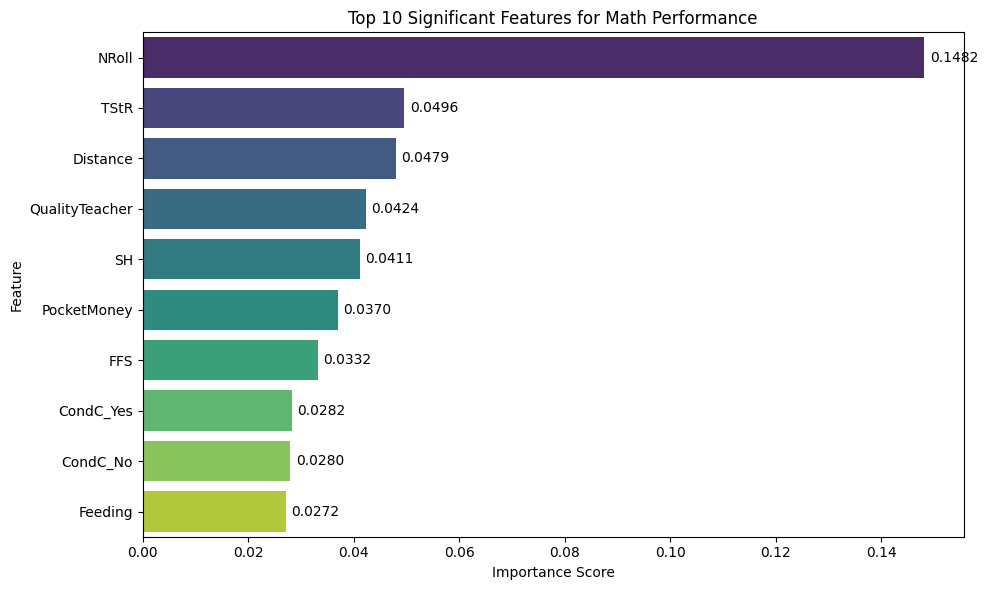

In [40]:
# Barplot with Precise Feature Importances (Top 10)
top_10 = importance_df.head(10).copy()
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=top_10, x="Importance", y="Feature", palette="viridis")

# Add exact values to bar tips
for i, (value, name) in enumerate(zip(top_10["Importance"], top_10["Feature"])):
    plt.text(value + 0.001, i, f"{value:.4f}", va='center')

plt.title("Top 10 Significant Features for Math Performance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()